# Setup Paths¶

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, GlobalAveragePooling2D 
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os

# Configuration and Hyperparameters

In [15]:
#входной размер изображений соответтсвует модели EfficiennetBo
IMG_SIZE = (224, 224)
TRAINING_DIR = "./train/"
VALIDATION_DIR = "./validation/"
CLASSES = ['land_cruser', 'qashqai', 'solyaris', 'vaz2110', 'x5_e70']

In [16]:

log_dir = "./logs_IMDG/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Create checkpoint callback to save model for later use
CHECKPOINT_PATH = "./checkpoint/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True)

# Load Data

In [17]:
# Загружаем набор изображений с помощью ImageDataGenerator с применением аугментации для тренировочного набора.
training_datagen = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                target_size=IMG_SIZE,
                                                                class_mode='categorical',
                                                                shuffle=False,batch_size=32)

Found 130 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [18]:
# Переобразуем  валидационные данные из формата ImageDataGenerator в numpy массив. 
# Это будет удобно для дальнейшей.....
images, labels = next(validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=45, shuffle=False))

Found 45 images belonging to 5 classes.


In [19]:
images.shape

(45, 256, 256, 3)

In [20]:
# Загрузим из "модельного зоопарка" EfficientNetB0, предварительно обученную на наборе Imagenet,
# исключив полносвязный верхинй слой и заморозив для обучения
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

2022-03-27 20:57:08.186283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 20:57:08.190940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 20:57:08.191381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 20:57:08.192341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [22]:
# Настройка архитектуры модели с обучаемыми верхними слоями
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs, training=False) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # объединить результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [23]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

In [24]:
# Компиляция
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                                           epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

/home/cooper/my_projects/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30


2022-03-27 20:57:13.977627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-03-27 20:57:14.322031: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5/5 [==============================] - 8s 828ms/step - loss: 1.8103 - accuracy: 0.1923 - val_loss: 1.5950 - val_accuracy: 0.2667
Epoch 2/30
5/5 [==============================] - 2s 485ms/step - loss: 1.6661 - accuracy: 0.2308 - val_loss: 1.5201 - val_accuracy: 0.3333
Epoch 3/30
5/5 [==============================] - 2s 535ms/step - loss: 1.5767 - accuracy: 0.3231 - val_loss: 1.4491 - val_accuracy: 0.3778
Epoch 4/30
5/5 [==============================] - 2s 467ms/step - loss: 1.4843 - accuracy: 0.3462 - val_loss: 1.3613 - val_accuracy: 0.4444
Epoch 5/30
5/5 [==============================] - 2s 473ms/step - loss: 1.4109 - accuracy: 0.4231 - val_loss: 1.2832 - val_accuracy: 0.6000
Epoch 6/30
5/5 [==============================] - 2s 546ms/step - loss: 1.2693 - accuracy: 0.5231 - val_loss: 1.2064 - val_accuracy: 0.6667
Epoch 7/30
5/5 [==============================] - 2s 483ms/step - loss: 1.1653 - accuracy: 0.6385 - val_loss: 1.1448 - val_accuracy: 0.6889
Epoch 8/30
5/5 [===============

In [25]:
# Оценка модели 
results_feature_extraction_model = model.evaluate(validation_generator)
results_feature_extraction_model

2/2 [==============================] - 0s 28ms/step - loss: 0.5515 - accuracy: 0.9111


[0.5514853596687317, 0.9111111164093018]

# Тонкая настройка

In [26]:
# Разморозим веса всей модели
base_model.trainable = True

#  10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [27]:
# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_unfreez = tf.keras.Model(inputs, outputs)

In [28]:
model_unfreez.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
___________________________________________

In [29]:

# Compile
model_unfreez.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_unfreez = model_unfreez.fit(train_generator,
                                           epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

Epoch 1/30
5/5 [==============================] - 6s 635ms/step - loss: 1.4637 - accuracy: 0.4154 - val_loss: 1.1301 - val_accuracy: 0.6222
Epoch 2/30
5/5 [==============================] - 2s 455ms/step - loss: 0.8948 - accuracy: 0.7615 - val_loss: 0.6260 - val_accuracy: 0.8889
Epoch 3/30
5/5 [==============================] - 2s 456ms/step - loss: 0.4886 - accuracy: 0.9462 - val_loss: 0.4082 - val_accuracy: 0.9111
Epoch 4/30
5/5 [==============================] - 2s 510ms/step - loss: 0.3434 - accuracy: 0.9308 - val_loss: 0.2763 - val_accuracy: 0.9111
Epoch 5/30
5/5 [==============================] - 2s 485ms/step - loss: 0.2741 - accuracy: 0.9538 - val_loss: 0.2272 - val_accuracy: 0.9333
Epoch 6/30
5/5 [==============================] - 2s 444ms/step - loss: 0.1933 - accuracy: 0.9692 - val_loss: 0.2668 - val_accuracy: 0.8889
Epoch 7/30
5/5 [==============================] - 2s 442ms/step - loss: 0.1784 - accuracy: 0.9769 - val_loss: 0.3398 - val_accuracy: 0.8667
Epoch 8/30
5/5 [====

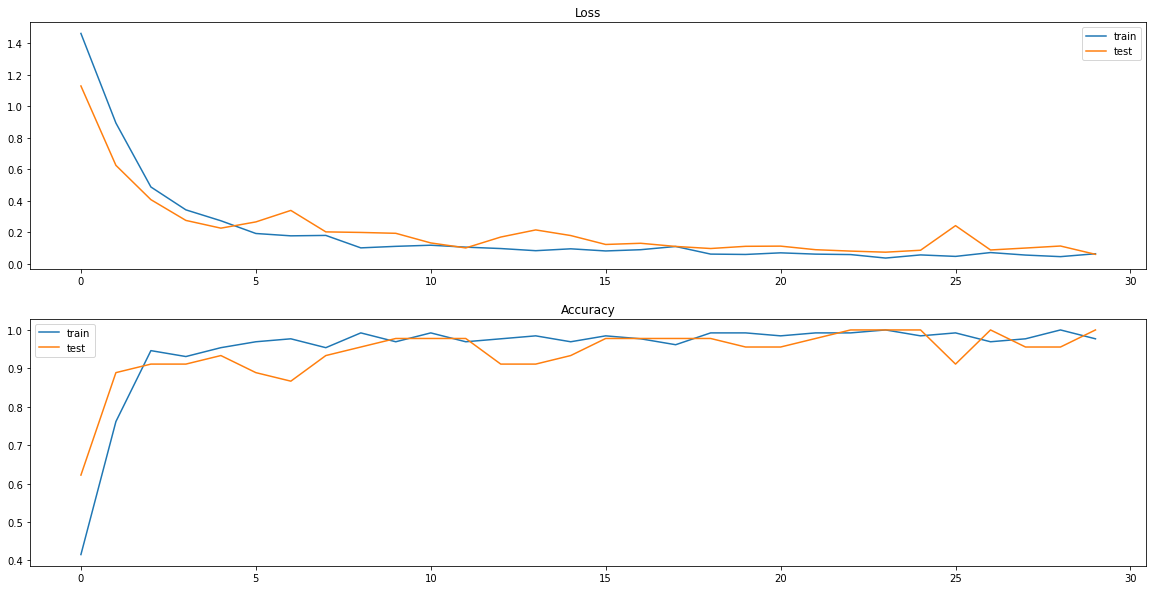

In [30]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history_unfreez.history['loss'], label='train')
plt.plot(history_unfreez.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_unfreez.history['accuracy'], label='train')
plt.plot(history_unfreez.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [31]:
#загрузим веса модели с наилучшими параметрами val_accuracy за период обучения
model_unfreez.load_weights(CHECKPOINT_PATH)

In [32]:
# Evaluate fine-tuned model on the whole test dataset
results_all_fine_tune = model_unfreez.evaluate(validation_generator)
results_all_fine_tune

2/2 [==============================] - 0s 27ms/step - loss: 0.0815 - accuracy: 1.0000


[0.08149441331624985, 1.0]

In [33]:
!tensorboard --logdir logs_IMDG/fit

2022-03-27 20:59:33.517902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 20:59:33.526151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 20:59:33.526412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL

In [35]:
# Save the entire model as a models/model/1
MODEL_DIR = "models/model"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = models/model/1

INFO:tensorflow:Assets written to: models/model/1/assets


/home/cooper/my_projects/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/cooper/my_projects/venv/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Predictions

In [36]:
def predictions_img(link = './test/2110.jpeg'):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 224x224 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image = np.expand_dims(img, axis=0)
    predictions = model_unfreez.predict(image, verbose=1)
    return CLASSES[np.argmax(predictions)],predictions

In [37]:
def show(link='./test/cruiser.jpg'):
    img = cv2.imread(link)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

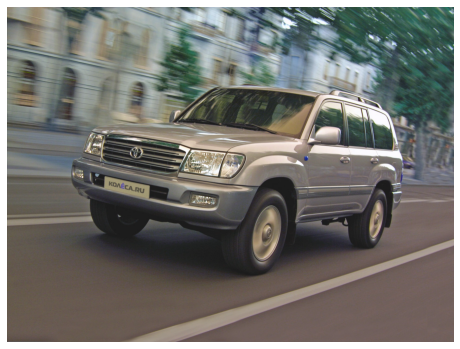

In [38]:
show('./test/cruiser.jpg')

In [39]:
predictions_img('./test/l4.jpeg')

1/1 [==============================] - 1s 1s/step


('land_cruser',
 array([[9.2060208e-01, 6.2442623e-04, 5.7360418e-02, 1.4200902e-02,
         7.2121806e-03]], dtype=float32))

# CONFUSION MATRIX

In [40]:
pred_probs = model_unfreez.predict(validation_generator, verbose=1)

2/2 [==============================] - 1s 55ms/step


In [41]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=5, norm=False, savefig=False): 
    y_pred = np.argmax(y_pred, axis=1)
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
  # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [42]:
labels.shape

(45, 5)

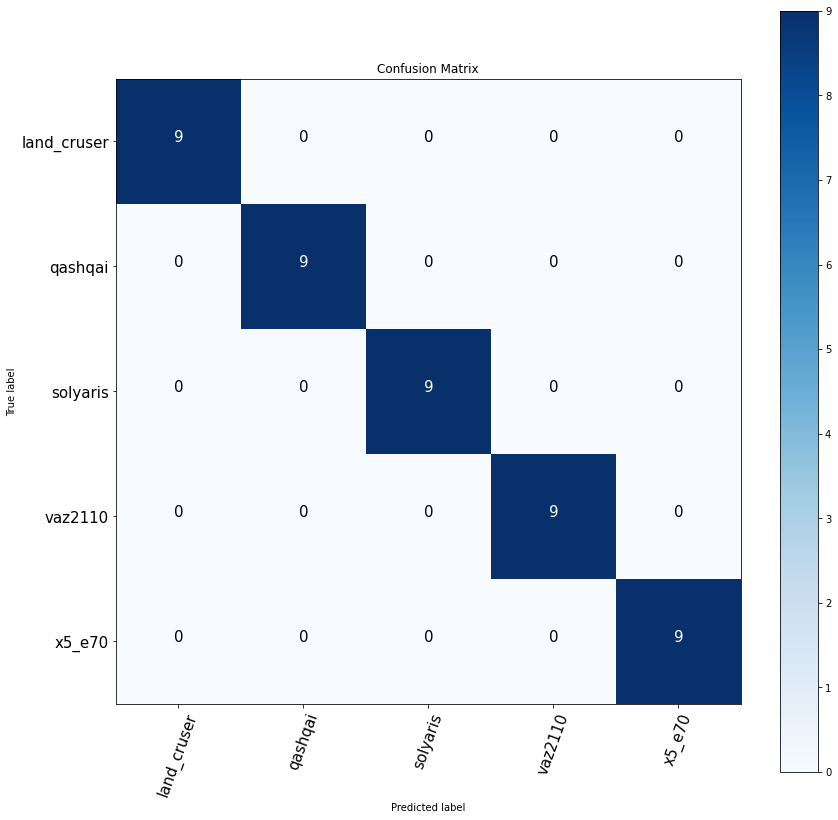

In [43]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=np.argmax(labels, axis=1),
                      y_pred=pred_probs,
                      classes=CLASSES,
                      figsize=(14, 14),
                      text_size=15,
                      norm=False,
                      savefig=True)

# Saliency

In [53]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img(link='./test/l4.jpeg'):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 300x300 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [54]:
# Siberian Husky's class ID in ImageNet
class_index = 1   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 5
image_expand, img = read_img(link='./test/l4.jpeg')
# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image_expand.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image_expand, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model_unfreez(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [55]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [56]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

0.0030588647
7.602534e-07

(135, 93)
(88, 11)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


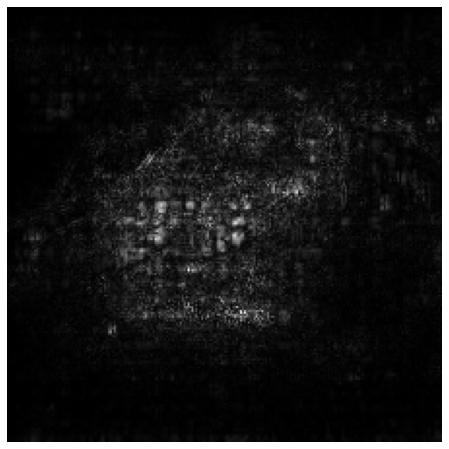

In [57]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

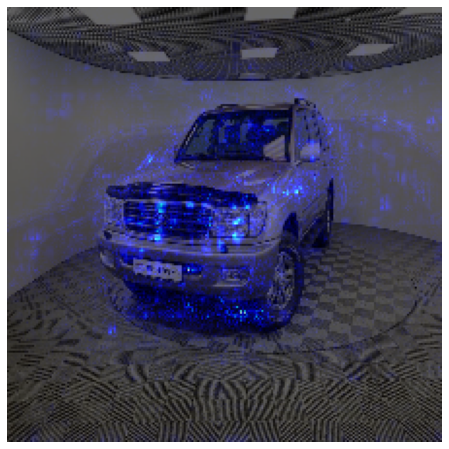

In [58]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color 
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.8, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()